In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
data = pd.read_excel('cleaned_excel_level_5_with_metadata.xlsx')

In [16]:
print(data.head())
data = data.drop(columns=['sample_ID'])
print("\nMissing values in each column:")
print(data.isnull().sum())
data = data.dropna()

# f and t
X = data.drop(columns=['RFI'])
y = data['RFI']

#one hot for the cat
X = pd.get_dummies(X, columns=['DNA_Batch', 'Farm_Code'], drop_first=True)

     sample_ID       RFI  1-14-0-10-45-34  172606-1  2-02-FULL-51-18  \
0  Sample_5001 -3.770883              0.0       0.0              0.0   
1  Sample_5002 -1.942963              0.0       0.0              0.0   
2  Sample_5003  2.489900              0.0       0.0              0.0   
3  Sample_5004  2.319945              0.0       0.0              0.0   
4  Sample_5005  0.396185              0.0       0.0              0.0   

   2013-40CM-41-45  20CM-2-55-15  40CM-4-68-19     70-9       A4b  ...  \
0              0.0           0.0           0.0  0.00000  0.019297  ...   
1              0.0           0.0           0.0  0.00000  0.000000  ...   
2              0.0           0.0           0.0  0.00000  0.000000  ...   
3              0.0           0.0           0.0  0.00000  0.000000  ...   
4              0.0           0.0           0.0  0.00645  0.000000  ...   

   Xanthomonadaceae_616012  Xenobiaceae  Xiphinematobacteraceae  \
0                      0.0          0.0                

In [17]:
# train 80
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)


In [18]:
# Ibase
rf = RandomForestRegressor(
    n_estimators=100,        
    max_depth=None,          
    min_samples_split=2,     
    min_samples_leaf=1,      
    random_state=1,          
    n_jobs=-1                
)


In [19]:
#same _base_M
print("\nTraining the Random Forest Regressor...")
rf.fit(X_train, y_train)



Training the Random Forest Regressor...


RandomForestRegressor(n_jobs=-1, random_state=1)

In [20]:
# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nRandom Forest Regression -- R^2 Score: {r2:.4f}, RMSE: {rmse:.4f}")



Random Forest Regression -- R^2 Score: 0.4595, RMSE: 2.1799


In [21]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)


In [22]:
# imp display
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
DNA_Batch_7                  0.195775
Clostridiaceae_222000        0.042138
Burkholderiaceae_A_580492    0.028378
Moraxellaceae                0.025371
Farm_Code_F                  0.023363
                               ...   
UBA10027                     0.000000
UBA1006                      0.000000
Immundisolibacteraceae       0.000000
Ethanoligenenaceae           0.000000
UBA10450                     0.000000
Length: 657, dtype: float64


/Users/ugalab4/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ugalab4/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ugalab4/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


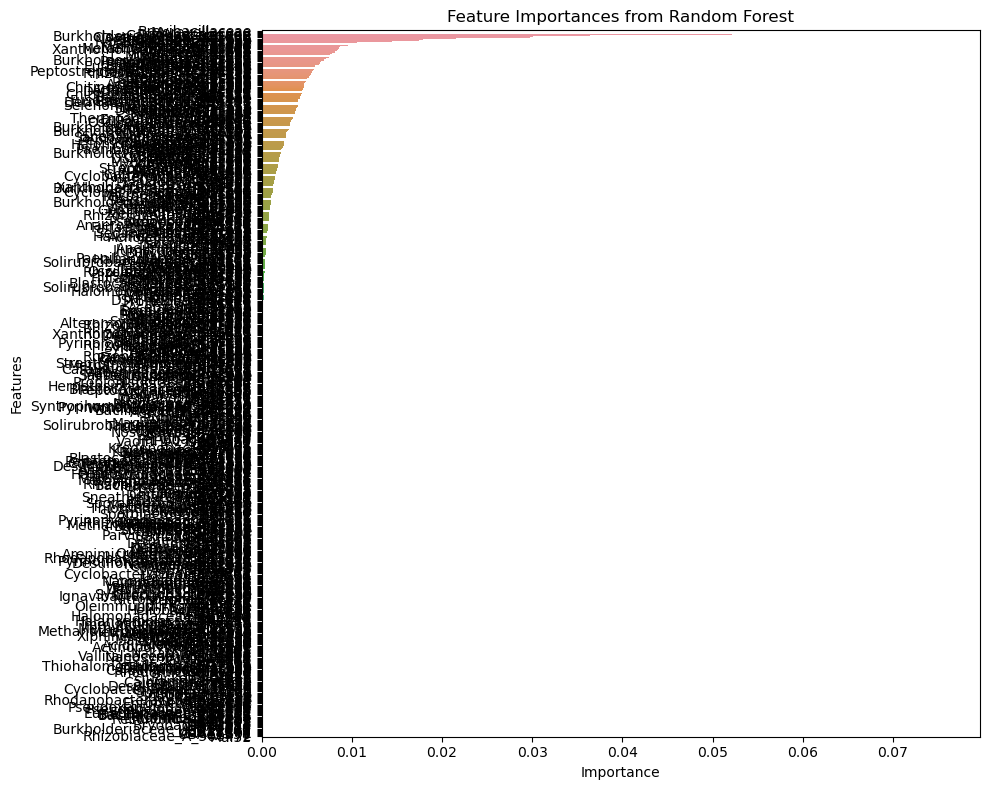

In [9]:

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

DNA_Batch_7                  0.195775
Clostridiaceae_222000        0.042138
Burkholderiaceae_A_580492    0.028378
Moraxellaceae                0.025371
Farm_Code_F                  0.023363
Neisseriaceae_563222         0.019798
Lactobacillaceae             0.019708
Caulobacteraceae             0.018368
Brevibacillaceae             0.012845
Micrococcaceae               0.010073
Dysgonomonadaceae            0.009923
Saccharimonadaceae           0.009776
Bifidobacteriaceae           0.009707
Enterococcaceae              0.009661
DNA_Batch_9                  0.009134
Eggerthellaceae              0.008973
Metamycoplasmataceae         0.008857
Domibacillaceae              0.008559
Mycobacteriaceae             0.008531
Methanobacteriaceae          0.008484
dtype: float64


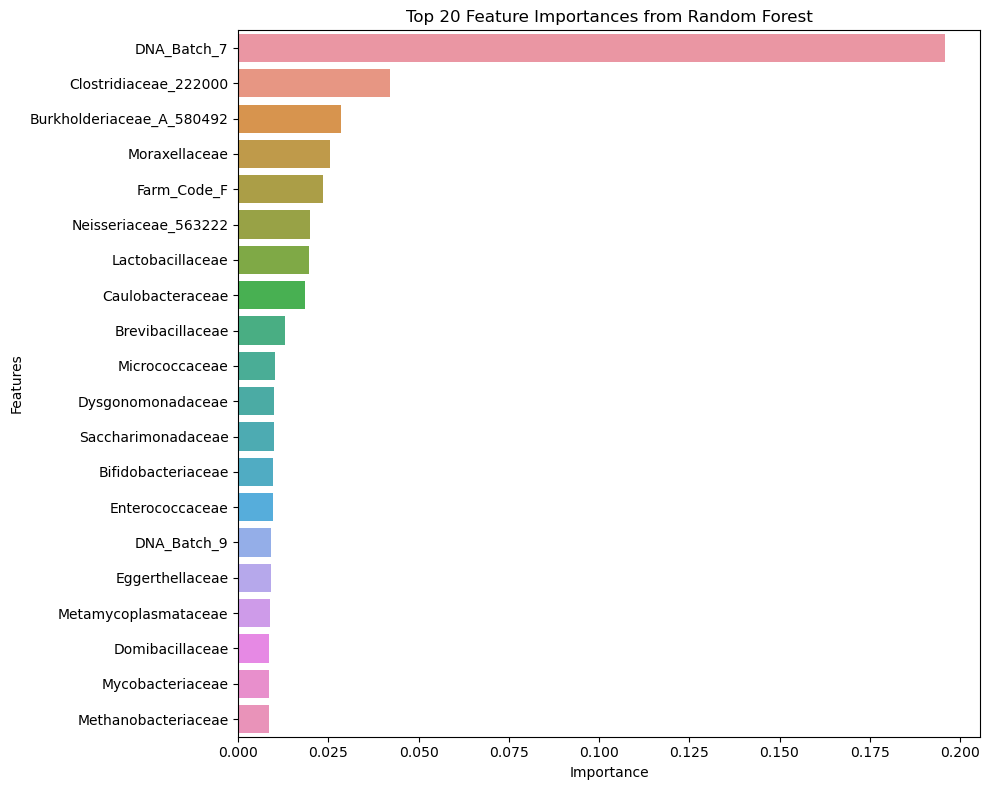

In [23]:
# only 20
top_features = feature_importances.head(20)

print(top_features)


plt.figure(figsize=(10, 8))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Now going for the base model optimization 

In [24]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(50, 1500),          # trees between 50 and 1500
    'max_depth': randint(5, 50),                 #mx dep 5 and 50
    'min_samples_split': randint(2, 20),         #  2 and 20
    'min_samples_leaf': randint(1, 20),          # lowest samples per_leaf bet 1 and 20
    'max_features': ['auto', 'sqrt', 'log2', None],  # lets try the various max_features
    'bootstrap': [True, False],                  # both bo0t and not
}



In [25]:
##ok now we have parameter array lets random search
rf = RandomForestRegressor(random_state=1, n_jobs=-1)


n_iter_search = 1000  # You can increase this number to try more combinations

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=n_iter_search,    
    cv=5,                   
    n_jobs=-1,               
    scoring='r2',
    verbose=2,
    random_state=1,
    return_train_score=True
)

print("\nPerforming randomized search for hyperparameter tuning...")
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print(f"\nBest Parameters from Randomized Search: {best_params}")
###########



Performing randomized search for hyperparameter tuning...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=5, min_samples_split=7, n_estimators=363; total time=   1.6s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=14, min_samples_split=19, n_estimators=676; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=136; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=18, min_samples_split=2, n_estimators=764; total time=   7.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=11, min_samples_split=16, n_estimators=423; total time=   2.3s
[CV] END bootstrap=False, max_depth=12, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=766; total time=  10.3s
[CV] END bootstrap=False, max_depth=36, max_featur

[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=1387; total time=  15.1s
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=784; total time=   2.5s
[CV] END bootstrap=True, max_depth=33, max_features=auto, min_samples_leaf=11, min_samples_split=2, n_estimators=113; total time=   0.0s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=846; total time=   2.8s
[CV] END bootstrap=True, max_depth=12, max_features=None, min_samples_leaf=2, min_samples_split=9, n_estimators=212; total time=   4.7s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=1, min_samples_split=19, n_estimators=864; total time=   4.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=18, min_samples_split=19, n_estimators=785; total time=   1.8s
[CV] END bootstrap=True, max_depth=27, ma

[CV] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=11, min_samples_split=16, n_estimators=612; total time=   0.0s
[CV] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=9, min_samples_split=13, n_estimators=1406; total time=   2.8s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=1170; total time=   3.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=16, min_samples_split=16, n_estimators=494; total time=   2.6s
[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=5, min_samples_split=16, n_estimators=224; total time=   3.3s
[CV] END bootstrap=True, max_depth=18, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=1425; total time=   0.0s
[CV] END bootstrap=True, max_depth=18, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=1425; total time=   0.0s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=5, min_samples_split=7, n_estimators=363; total time=   2.3s
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=14, min_samples_split=17, n_estimators=1069; total time=   2.9s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=136; total time=   1.6s
[CV] END bootstrap=True, max_depth=19, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=515; total time=   4.1s
[CV] END bootstrap=False, max_depth=39, max_features=sqrt, min_samples_leaf=12, min_samples_split=7, n_estimators=1382; total time=   3.5s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=1214; total time=   2.3s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=1358; total time=  17.0s
[CV] END bootstrap=False, max_depth=9,

[CV] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=19, min_samples_split=7, n_estimators=964; total time=   2.2s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=226; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=999; total time=   3.6s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=18, min_samples_split=2, n_estimators=764; total time=   7.7s
[CV] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=7, min_samples_split=2, n_estimators=1171; total time=   2.4s
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=17, min_samples_split=19, n_estimators=1304; total time=   2.2s
[CV] END bootstrap=True, max_depth=27, max_features=None, min_samples_leaf=6, min_samples_split=3, n_estimators=655; total time=   8.0s
[CV] END bootstrap=True, max_depth=37, ma

[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=1100; total time=   0.0s
[CV] END bootstrap=False, max_depth=23, max_features=auto, min_samples_leaf=14, min_samples_split=12, n_estimators=329; total time=   0.0s
[CV] END bootstrap=False, max_depth=23, max_features=auto, min_samples_leaf=14, min_samples_split=12, n_estimators=329; total time=   0.0s
[CV] END bootstrap=False, max_depth=23, max_features=auto, min_samples_leaf=14, min_samples_split=12, n_estimators=329; total time=   0.0s
[CV] END bootstrap=False, max_depth=23, max_features=auto, min_samples_leaf=14, min_samples_split=12, n_estimators=329; total time=   0.0s
[CV] END bootstrap=True, max_depth=22, max_features=None, min_samples_leaf=11, min_samples_split=2, n_estimators=1214; total time=  12.1s
[CV] END bootstrap=False, max_depth=39, max_features=sqrt, min_samples_leaf=12, min_samples_split=7, n_estimators=1382; total time=   3.1s
[CV] END bootstrap=True, max

[CV] END bootstrap=True, max_depth=47, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=175; total time=   0.9s
[CV] END bootstrap=True, max_depth=46, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimators=1157; total time=   2.9s
[CV] END bootstrap=False, max_depth=21, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=449; total time=   5.3s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=11, n_estimators=1496; total time=  18.9s
[CV] END bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=1021; total time=   1.5s
[CV] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=7, min_samples_split=15, n_estimators=1486; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=18, min_samples_split=13, n_estimators=190; total time=   0.8s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=44, max_features=auto, min_samples_leaf=12, min_samples_split=11, n_estimators=1137; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=17, n_estimators=1089; total time=   9.4s
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=18, min_samples_split=15, n_estimators=755; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=1158; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=1158; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=1158; total time=   0.0s
[CV] END bootstrap=False, max_depth=39, max_features=log2, min_samples_leaf=5, min_samples_split=16, n_estimators=1162; total time=   1.4s
[CV] END bootstrap=False, max_de

[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=5, min_samples_split=9, n_estimators=1307; total time=   0.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=5, min_samples_split=9, n_estimators=1307; total time=   0.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=5, min_samples_split=9, n_estimators=1307; total time=   0.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=5, min_samples_split=9, n_estimators=1307; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=9, min_samples_split=11, n_estimators=252; total time=   0.5s
[CV] END bootstrap=False, max_depth=49, max_features=None, min_samples_leaf=14, min_samples_split=19, n_estimators=1004; total time=  10.3s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=1315; total time=   2.7s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=7, min_samples_split=10, n_estimators=968; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=7, n_estimators=1140; total time=  13.3s
[CV] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=16, min_samples_split=18, n_estimators=132; total time=   0.6s
[CV] END bootstrap=True, max_depth=12, max_features=log2, min_samples_leaf=8, min_samples_split=11, n_estimators=1192; total time=   2.7s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=17, n_estimators=204; total time=   2.6s
[CV] END bootstrap=True, max_depth=12, max_features=None, min_samples_leaf=15, min_samples_split=17, n_estimators=286; total time=   2.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=7, min_samples_split=6, n_estimators=807; total time=   1.8s
[CV] END bootstrap=True, max_depth=11, m

[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=5, min_samples_split=16, n_estimators=224; total time=   3.2s
[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=5, min_samples_split=16, n_estimators=224; total time=   2.5s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=17, min_samples_split=14, n_estimators=203; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=17, min_samples_split=14, n_estimators=203; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=17, min_samples_split=14, n_estimators=203; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=17, min_samples_split=14, n_estimators=203; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=17, min_samples_split=14, n_estimators=203; total time=   0.0s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=392; total time=   0.0s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=392; total time=   0.0s
[CV] END bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=844; total time=   0.0s
[CV] END bootstrap=True, max_depth=22, max_features=None, min_samples_leaf=11, min_samples_split=18, n_estimators=426; total time=   4.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=763; total time=   5.3s
[CV] END bootstrap=False, max_depth=24, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=226; total time=   5.3s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=9, min_samples_split=5, n_estimators=1327; total time=   6.6s
[CV] END bootstrap=False, max_depth=4

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1176; total time=   3.3s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=1147; total time=   1.8s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=676; total time=   1.6s
[CV] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1278; total time=   2.3s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1201; total time=  10.4s
[CV] END bootstrap=True, max_depth=48, max_features=None, min_samples_leaf=12, min_samples_split=11, n_estimators=506; total time=   3.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=164; total time=   0.3s
[CV] END bootstrap=False, max_depth=8,

[CV] END bootstrap=False, max_depth=42, max_features=auto, min_samples_leaf=11, min_samples_split=3, n_estimators=1331; total time=   0.0s
[CV] END bootstrap=False, max_depth=42, max_features=auto, min_samples_leaf=11, min_samples_split=3, n_estimators=1331; total time=   0.0s
[CV] END bootstrap=True, max_depth=13, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=892; total time=   8.5s
[CV] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=4, min_samples_split=16, n_estimators=96; total time=   1.3s
[CV] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=14, min_samples_split=3, n_estimators=1368; total time=   2.5s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=19, min_samples_split=7, n_estimators=1115; total time=  11.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=1408; total time=   4.3s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=13, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=89; total time=   0.2s
[CV] END bootstrap=True, max_depth=36, max_features=None, min_samples_leaf=9, min_samples_split=13, n_estimators=1202; total time=  11.0s
[CV] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=366; total time=   1.0s
[CV] END bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=7, min_samples_split=13, n_estimators=1091; total time=   1.7s
[CV] END bootstrap=False, max_depth=18, max_features=None, min_samples_leaf=9, min_samples_split=8, n_estimators=578; total time=   7.5s
[CV] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=17, min_samples_split=9, n_estimators=627; total time=   4.0s
[CV] END bootstrap=True, max_depth=19, max_features=auto, min_samples_leaf=16, min_samples_split=14, n_estimators=1416; total time=   0.0s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=14, min_samples_split=9, n_estimators=184; total time=   1.1s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=17, n_estimators=1481; total time=  13.6s
[CV] END bootstrap=True, max_depth=19, max_features=None, min_samples_leaf=9, min_samples_split=12, n_estimators=720; total time=   5.9s
[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=19, min_samples_split=2, n_estimators=1247; total time=   2.4s
[CV] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=17, min_samples_split=19, n_estimators=1381; total time=   2.4s
[CV] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=13, min_samples_split=4, n_estimators=553; total time=   4.1s
[CV] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=16, min_samples_split=17, n_estimators=1320; total time=   2.0s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=14, min_samples_split=8, n_estimators=1284; total time=  17.9s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=17, min_samples_split=10, n_estimators=188; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=245; total time=   2.4s
[CV] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=11, min_samples_split=18, n_estimators=501; total time=   3.4s
[CV] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=650; total time=   4.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=16, min_samples_split=19, n_estimators=570; total time=   3.0s
[CV] END bootstrap=True, max_depth=31, max_features=None, min_samples_leaf=15, min_samples_split=6, n_estimators=182; total time=   3.2s
[CV] END bootstrap=True, max_depth=4

[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=12, min_samples_split=19, n_estimators=287; total time=   0.6s
[CV] END bootstrap=False, max_depth=22, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=846; total time=   1.6s
[CV] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1481; total time=   4.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=964; total time=   1.4s
[CV] END bootstrap=False, max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=19, n_estimators=1223; total time=  11.0s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=10, min_samples_split=16, n_estimators=1016; total time=   1.3s
[CV] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=2, min_samples_split=13, n_estimators=893; total time=   0.0s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=17, max_features=auto, min_samples_leaf=13, min_samples_split=6, n_estimators=731; total time=   0.0s
[CV] END bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=209; total time=   5.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=52; total time=   1.1s
[CV] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=19, min_samples_split=3, n_estimators=555; total time=   2.8s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=1345; total time=   5.2s
[CV] END bootstrap=True, max_depth=27, max_features=None, min_samples_leaf=11, min_samples_split=7, n_estimators=1143; total time=  10.5s
[CV] END bootstrap=True, max_depth=48, max_features=auto, min_samples_leaf=13, min_samples_split=17, n_estimators=420; total time=   0.0s
[CV] END bootstrap=True, max_depth=4

[CV] END bootstrap=False, max_depth=19, max_features=sqrt, min_samples_leaf=19, min_samples_split=10, n_estimators=1177; total time=   2.2s
[CV] END bootstrap=False, max_depth=36, max_features=sqrt, min_samples_leaf=11, min_samples_split=17, n_estimators=345; total time=   1.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=11, min_samples_split=5, n_estimators=521; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=11, min_samples_split=5, n_estimators=521; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=11, min_samples_split=5, n_estimators=521; total time=   0.1s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=11, min_samples_split=5, n_estimators=521; total time=   0.0s
[CV] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=11, min_samples_split=5, n_estimators=521; total time=   0.0s
[CV] END bootstrap=True, max_depth=1

[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=929; total time=   1.5s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=8, min_samples_split=12, n_estimators=1227; total time=   1.9s
[CV] END bootstrap=True, max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1005; total time=   2.4s
[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=14, min_samples_split=8, n_estimators=1284; total time=  12.5s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=17, min_samples_split=5, n_estimators=441; total time=   0.0s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=17, min_samples_split=5, n_estimators=441; total time=   0.0s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=17, min_samples_split=5, n_estimators=441; total time=   0.0s
[CV] END bootstrap=True, max_depth=11,

[CV] END bootstrap=False, max_depth=37, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1243; total time=   0.0s
[CV] END bootstrap=False, max_depth=37, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1243; total time=   0.0s
[CV] END bootstrap=False, max_depth=37, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1243; total time=   0.0s
[CV] END bootstrap=False, max_depth=37, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1243; total time=   0.0s
[CV] END bootstrap=False, max_depth=37, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1243; total time=   0.0s
[CV] END bootstrap=True, max_depth=49, max_features=None, min_samples_leaf=18, min_samples_split=12, n_estimators=838; total time=   7.1s
[CV] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=18, n_estimators=1218; total time=   3.3s
[CV] END bootstrap=True,

[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=5, min_samples_split=7, n_estimators=363; total time=   1.2s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=226; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=999; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=999; total time=   2.8s
[CV] END bootstrap=False, max_depth=32, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=460; total time=   5.7s
[CV] END bootstrap=False, max_depth=32, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=460; total time=   6.6s
[CV] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=12, min_samples_split=17, n_estimators=888; total time=   2.1s
[CV] END bootstrap=True, max_depth=12, max_

[CV] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=4, min_samples_split=17, n_estimators=1446; total time=   5.3s
[CV] END bootstrap=False, max_depth=12, max_features=None, min_samples_leaf=5, min_samples_split=3, n_estimators=740; total time=  11.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=1408; total time=   5.6s
[CV] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=292; total time=   2.0s
[CV] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=13, min_samples_split=5, n_estimators=1050; total time=  13.2s
[CV] END bootstrap=False, max_depth=43, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=613; total time=   4.3s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=14, min_samples_split=15, n_estimators=496; total time=   0.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=16, min_samples_split=7, n_estimators=109; total time=   1.2s
[CV] END bootstrap=True, max_depth=39, max_features=None, min_samples_leaf=11, min_samples_split=14, n_estimators=666; total time=   5.3s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=7, min_samples_split=11, n_estimators=489; total time=   0.8s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=15, min_samples_split=11, n_estimators=1177; total time=   1.6s
[CV] END bootstrap=True, max_depth=46, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=1063; total time=   9.3s
[CV] END bootstrap=True, max_depth=23, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1428; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=13, n_estimators=221; total time=   1.6s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=41, max_features=sqrt, min_samples_leaf=10, min_samples_split=13, n_estimators=931; total time=   3.1s
[CV] END bootstrap=False, max_depth=49, max_features=sqrt, min_samples_leaf=10, min_samples_split=7, n_estimators=401; total time=   2.3s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=417; total time=   1.4s
[CV] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=16, min_samples_split=18, n_estimators=132; total time=   0.8s
[CV] END bootstrap=True, max_depth=12, max_features=log2, min_samples_leaf=8, min_samples_split=11, n_estimators=1192; total time=   2.2s
[CV] END bootstrap=False, max_depth=36, max_features=log2, min_samples_leaf=12, min_samples_split=17, n_estimators=1055; total time=   1.5s
[CV] END bootstrap=False, max_depth=16, max_features=None, min_samples_leaf=11, min_samples_split=5, n_estimators=729; total time=   7.6s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=36, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=860; total time=   1.8s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=16, min_samples_split=11, n_estimators=849; total time=   1.7s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=10, min_samples_split=16, n_estimators=1016; total time=   1.9s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=289; total time=   0.6s
[CV] END bootstrap=True, max_depth=23, max_features=log2, min_samples_leaf=14, min_samples_split=3, n_estimators=1382; total time=   2.3s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=18, n_estimators=630; total time=   0.9s
[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=7, min_samples_split=13, n_estimators=1374; total time=  14.8s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=52; total time=   1.9s
[CV] END bootstrap=True, max_depth=12, max_features=log2, min_samples_leaf=4, min_samples_split=17, n_estimators=1000; total time=   4.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=607; total time=   0.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=607; total time=   0.0s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=607; total time=   0.1s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=607; total time=   0.0s
[CV] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=8, min_samples_split=15, n_estimators=1495; total time=  17.0s
[CV] END bootstrap=False, max_depth=44, m

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=19, min_samples_split=8, n_estimators=1279; total time=   2.2s
[CV] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=940; total time=   2.4s
[CV] END bootstrap=False, max_depth=28, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=361; total time=   1.1s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=13, min_samples_split=2, n_estimators=147; total time=   0.2s
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=16, min_samples_split=11, n_estimators=849; total time=   2.0s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=10, min_samples_split=16, n_estimators=1016; total time=   1.7s
[CV] END bootstrap=True, max_depth=39, max_features=None, min_samples_leaf=11, min_samples_split=17, n_estimators=679; total time=   4.4s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=7, min_samples_split=19, n_estimators=1066; total time=   2.8s
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=16, min_samples_split=4, n_estimators=77; total time=   2.1s
[CV] END bootstrap=False, max_depth=46, max_features=sqrt, min_samples_leaf=17, min_samples_split=5, n_estimators=256; total time=   2.1s
[CV] END bootstrap=False, max_depth=41, max_features=sqrt, min_samples_leaf=10, min_samples_split=13, n_estimators=931; total time=   2.5s
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1082; total time=   3.0s
[CV] END bootstrap=False, max_depth=49, max_features=None, min_samples_leaf=3, min_samples_split=16, n_estimators=167; total time=   2.6s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=19, n_estimators=1070; total time=   2.0s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=3, min_samples_split=16, n_estimators=648; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=13, min_samples_split=7, n_estimators=1271; total time=  17.4s
[CV] END bootstrap=True, max_depth=45, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=1318; total time=  16.0s
[CV] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=7, min_samples_split=15, n_estimators=1486; total time=   7.1s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=9, min_samples_split=5, n_estimators=1327; total time=   6.4s
[CV] END bootstrap=False, max_depth=24, max_features=log2, min_samples_leaf=7, min_samples_split=13, n_estimators=1091; total time=   4.8s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=7, min_samples_split=15, n_estimators=541; total time=   7.9s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=17, n_estimators=637; total time=  12.3s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=14, min_samples_split=10, n_estimators=544; total time=   4.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=17, min_samples_split=3, n_estimators=799; total time=   0.0s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=1014; total time=   2.9s
[CV] END bootstrap=False, max_depth=38, max_features=log2, min_samples_leaf=17, min_samples_split=2, n_estimators=303; total time=   2.0s
[CV] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=11, min_samples_split=10, n_estimators=159; total time=   3.5s
[CV] END bootstrap=False, max_depth=31, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=687; total time=   0.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=True, max_depth=29, max_features=auto, min_samples_leaf=19, min_samples_split=19, n_estimators=261; total time=   0.0s
[CV] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, n_estimators=1010; total time=   1.7s
[CV] END bootstrap=False, max_depth=49, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=1055; total time=  15.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=11, n_estimators=969; total time=  11.0s
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=12, min_samples_split=15, n_estimators=1340; total time=  14.4s
[CV] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=749; total time=   2.2s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=425; total time=   1.1s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=16, min_samples_split=19, n_estimators=570; total time=   2.8s
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=6, min_samples_split=14, n_estimators=1495; total time=   3.7s
[CV] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=833; total time=   2.6s
[CV] END bootstrap=True, max_depth=27, max_features=None, min_samples_leaf=11, min_samples_split=7, n_estimators=1143; total time=  11.5s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=13, min_samples_split=13, n_estimators=1252; total time=  10.0s
[CV] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=8, min_samples_split=11, n_estimators=514; total time=   4.7s
[CV] END bootstrap=False, max_depth=45, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=1049; total time=   1.8s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=48, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=48, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=48, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=48, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=19, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=954; total time=   8.5s
[CV] END bootstrap=False, max_depth=21, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=210; total time=   3.0s
[CV] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=18, min_samples_split=7, n_estimators=1121; total time=   1.7s
[CV] END bootstrap=False, max_depth=38, m

[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=6, min_samples_split=16, n_estimators=1175; total time=   4.5s
[CV] END bootstrap=True, max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1002; total time=   4.6s
[CV] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=9, min_samples_split=16, n_estimators=1441; total time=   3.7s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49,

[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=959; total time=   4.0s
[CV] END bootstrap=False, max_depth=36, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=766; total time=   2.4s
[CV] END bootstrap=True, max_depth=48, max_features=None, min_samples_leaf=12, min_samples_split=11, n_estimators=506; total time=   7.4s
[CV] END bootstrap=False, max_depth=45, max_features=sqrt, min_samples_leaf=10, min_samples_split=8, n_estimators=1315; total time=   4.1s
[CV] END bootstrap=True, max_depth=23, max_features=log2, min_samples_leaf=8, min_samples_split=9, n_estimators=560; total time=   3.8s
[CV] END bootstrap=True, max_depth=48, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=218; total time=   2.0s
[CV] END bootstrap=False, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1407; total time=  22.5s
[CV] END bootstrap=True, max_depth=28,

[CV] END bootstrap=True, max_depth=44, max_features=sqrt, min_samples_leaf=9, min_samples_split=11, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=19, max_features=sqrt, min_samples_leaf=1, min_samples_split=9, n_estimators=471; total time=   3.9s
[CV] END bootstrap=False, max_depth=42, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=102; total time=   3.5s
[CV] END bootstrap=False, max_depth=9, max_features=None, min_samples_leaf=10, min_samples_split=7, n_estimators=984; total time=  12.6s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=18, min_samples_split=5, n_estimators=271; total time=   6.9s
[CV] END bootstrap=False, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=11, n_estimators=456; total time=   0.9s
[CV] END bootstrap=True, max_depth=47, max_features=None, min_samples_leaf=3, min_samples_split=15, n_estimators=587; total time=   6.4s
[CV] END bootstrap=False, max_depth=37, 

[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=846; total time=   1.8s
[CV] END bootstrap=False, max_depth=48, max_features=None, min_samples_leaf=16, min_samples_split=9, n_estimators=462; total time=   5.9s
[CV] END bootstrap=True, max_depth=43, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=1072; total time=   3.0s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=1, min_samples_split=19, n_estimators=864; total time=   2.7s
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=7, min_samples_split=3, n_estimators=1163; total time=   3.4s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=16, n_estimators=1441; total time=   7.0s
[CV] END bootstrap=True, max_depth=28, max_features=None, min_samples_leaf=9, min_samples_split=12, n_estimators=71; total time=   2.1s
[CV] END bootstrap=False, max_depth=7, m

[CV] END bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=944; total time=   0.0s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1233; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=15, min_samples_split=8, n_estimators=872; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=15, min_samples_split=8, n_estimators=872; total time=   0.0s
[CV] END bootstrap=False, max_depth=34, max_features=auto, min_samples_leaf=16, min_samples_split=11, n_estimators=1103; total time=   0.0s
[CV] END bootstrap=False, max_depth=29, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1382; total time=   0.0s
[CV] END bootstrap=False, max_depth=29, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=1382; total time=   0.0s
[CV] END bootstrap=False, max_

/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1350 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
631 fits failed with the following error:
Traceback (most recent call last):
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter


Best Parameters from Randomized Search: {'bootstrap': True, 'max_depth': 27, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 655}


In [30]:
#sav outs
results_df = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']]
results_df['rmse_test_score'] = np.sqrt(1 - results_df['mean_test_score'])  


results_df.to_excel("base_model_with_metadata_optimization.xlsx", index=False)



[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=17, n_estimators=1089; total time=  10.6s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=13, min_samples_split=7, n_estimators=1271; total time=  11.6s
[CV] END bootstrap=True, max_depth=31, max_features=None, min_samples_leaf=13, min_samples_split=18, n_estimators=999; total time=   7.5s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=1245; total time=   2.2s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=11, min_samples_split=10, n_estimators=289; total time=   0.7s
[CV] END bootstrap=False, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=589; total time=   6.8s
[CV] END bootstrap=False, max_depth=45, max_features=None, min_samples_leaf=11, min_samples_split=18, n_estimators=266; total time=   3.3s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=True, max_depth=19, max_features=None, min_samples_leaf=9, min_samples_split=12, n_estimators=720; total time=  12.1s
[CV] END bootstrap=True, max_depth=43, max_features=sqrt, min_samples_leaf=14, min_samples_split=12, n_estimators=1189; total time=   4.9s
[CV] END bootstrap=False, max_depth=24, max_features=auto, min_samples_leaf=12, min_samples_split=7, n_estimators=413; total time=   0.0s
[CV] END bootstrap=False, max_depth=24, max_features=auto, min_samples_leaf=12, min_samples_split=7, n_estimators=413; total time=   0.0s
[CV] END bootstrap=True, max_depth=43, max_features=None, min_samples_leaf=17, min_samples_split=11, n_estimators=927; total time=   6.7s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=13, min_samples_split=9, n_estimators=528; total time=   2.3s
[CV] END bootstrap=True, max_depth=23, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=203; total time=   0.0s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=10, min_samples_split=12, n_estimators=1208; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=7, n_estimators=990; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=7, n_estimators=990; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=7, n_estimators=990; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=7, n_estimators=990; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=9, n_estimators=180; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=9, n_estimators=180; total time=   0.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=13, n_estimators=580; total time=   3.7s
[CV] END bootstrap=False, max_depth=21, max_features=sqrt, min_samples_leaf=8, min_samples_split=11, n_estimators=1067; total time=   3.9s
[CV] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=711; total time=  10.3s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=14, min_samples_split=3, n_estimators=460; total time=   0.0s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=14, min_samples_split=3, n_estimators=460; total time=   0.0s
[CV] END bootstrap=True, max_depth=42, max_features=auto, min_samples_leaf=14, min_samples_split=3, n_estimators=460; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=574; total time=   0.0s
[CV] END bootstrap=False, max_depth=47, m

[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=49, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=882; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=6, min_samples_split=14, n_estimators=1495; total time=   4.4s
[CV] END bootstrap=True, max_depth=17, max_features=log2, min_samples_leaf=1, min_samples_split=14, n_estimators=354; total time=   3.5s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=13, min_samples_split=17, n_estimators=822; total time=  11.9s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=17, n_estimators=204; total time=   6.0s
[CV] END bootstrap=False, max_depth=24

[CV] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=18, min_samples_split=18, n_estimators=869; total time=   1.1s
[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=144; total time=   0.0s
[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=144; total time=   0.0s
[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=144; total time=   0.0s
[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=144; total time=   0.0s
[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=8, min_samples_split=14, n_estimators=144; total time=   0.0s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=10, min_samples_split=9, n_estimators=793; total time=   1.6s
[CV] END bootstrap=False, max_depth=45, 

[CV] END bootstrap=False, max_depth=22, max_features=log2, min_samples_leaf=6, min_samples_split=14, n_estimators=905; total time=   3.5s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=475; total time=   0.0s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=475; total time=   0.0s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=475; total time=   0.0s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=475; total time=   0.0s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=475; total time=   0.0s
[CV] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=17, min_samples_split=15, n_estimators=1435; total time=   3.6s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=True, max_depth=26, max_features=log2, min_samples_leaf=8, min_samples_split=11, n_estimators=1070; total time=   4.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1299; total time=   5.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1176; total time=   7.7s
[CV] END bootstrap=False, max_depth=32, max_features=None, min_samples_leaf=15, min_samples_split=15, n_estimators=1020; total time=  10.1s
[CV] END bootstrap=False, max_depth=19, max_features=sqrt, min_samples_leaf=19, min_samples_split=10, n_estimators=1177; total time=   3.8s
[CV] END bootstrap=True, max_depth=48, max_features=None, min_samples_leaf=12, min_samples_split=15, n_estimators=319; total time=   4.5s
[CV] END bootstrap=True, max_depth=12, max_features=log2, min_samples_leaf=4, min_samples_split=17, n_estimators=1000; total time=   3.4s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=750; total time=   2.0s
[CV] END bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=14, min_samples_split=2, n_estimators=343; total time=   2.5s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=13, n_estimators=580; total time=   4.0s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=13, min_samples_split=17, n_estimators=822; total time=  11.7s
[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=1093; total time=   6.4s
[CV] END bootstrap=False, max_depth=46, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1491; total time=   0.0s
[CV] END bootstrap=False, max_depth=46, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1491; total time=   0.0s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=True, max_depth=35, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=168; total time=   0.0s
[CV] END bootstrap=True, max_depth=35, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=168; total time=   0.0s
[CV] END bootstrap=True, max_depth=35, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=168; total time=   0.0s
[CV] END bootstrap=True, max_depth=35, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=168; total time=   0.0s
[CV] END bootstrap=False, max_depth=48, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=635; total time=   1.2s
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=14, min_samples_split=13, n_estimators=645; total time=   1.0s
[CV] END bootstrap=True, max_depth=43, max_features=sqrt, min_samples_leaf=14, min_samples_split=12, n_estimators=1189; total time=   2.4s
[CV] END bootstrap=False, max_depth=41, ma

[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=610; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=610; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=610; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=610; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=5, n_estimators=610; total time=   0.0s
[CV] END bootstrap=True, max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1002; total time=   4.7s
[CV] END bootstrap=False, max_depth=44, max_features=log2, min_samples_leaf=11, min_samples_split=16, n_estimators=266; total time=   2.4s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=42, max_features=log2, min_samples_leaf=12, min_samples_split=14, n_estimators=1122; total time=   5.2s
[CV] END bootstrap=False, max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=276; total time=   4.9s
[CV] END bootstrap=False, max_depth=29, max_features=None, min_samples_leaf=10, min_samples_split=4, n_estimators=868; total time=  13.8s
[CV] END bootstrap=False, max_depth=46, max_features=sqrt, min_samples_leaf=17, min_samples_split=15, n_estimators=562; total time=   5.1s
[CV] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=14, min_samples_split=3, n_estimators=1417; total time=  16.1s
[CV] END bootstrap=False, max_depth=15, max_features=None, min_samples_leaf=16, min_samples_split=7, n_estimators=109; total time=   2.9s
[CV] END bootstrap=False, max_depth=19, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=1495; total time=  16.4s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=False, max_depth=28, max_features=None, min_samples_leaf=12, min_samples_split=3, n_estimators=1456; total time=  12.2s
[CV] END bootstrap=False, max_depth=41, max_features=sqrt, min_samples_leaf=10, min_samples_split=13, n_estimators=931; total time=   1.9s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=11, min_samples_split=7, n_estimators=160; total time=   0.8s
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1082; total time=   2.7s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=417; total time=   1.0s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=13, min_samples_split=13, n_estimators=1252; total time=   8.7s
[CV] END bootstrap=True, max_depth=18, max_features=log2, min_samples_leaf=4, min_samples_split=14, n_estimators=472; total time=   0.9s
[CV] END bootstrap=True, max_depth=8

[CV] END bootstrap=True, max_depth=43, max_features=None, min_samples_leaf=16, min_samples_split=19, n_estimators=344; total time=   5.2s
[CV] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=16, min_samples_split=16, n_estimators=798; total time=   3.5s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=8, min_samples_split=12, n_estimators=1227; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=765; total time=  14.4s
[CV] END bootstrap=False, max_depth=17, max_features=log2, min_samples_leaf=17, min_samples_split=12, n_estimators=274; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=1188; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=245; total time=   2.9s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=45, max_features=None, min_samples_leaf=11, min_samples_split=18, n_estimators=266; total time=   3.5s
[CV] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=933; total time=   2.0s
[CV] END bootstrap=True, max_depth=18, max_features=None, min_samples_leaf=9, min_samples_split=11, n_estimators=1000; total time=   8.2s
[CV] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=12, min_samples_split=6, n_estimators=707; total time=   5.6s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=7, min_samples_split=15, n_estimators=1387; total time=   0.0s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=7, min_samples_split=15, n_estimators=1387; total time=   0.0s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=7, min_samples_split=15, n_estimators=1387; total time=   0.0s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=18, min_samples_split=5, n_estimators=271; total time=   4.8s
[CV] END bootstrap=True, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1052; total time=  18.7s
[CV] END bootstrap=True, max_depth=43, max_features=sqrt, min_samples_leaf=14, min_samples_split=12, n_estimators=1189; total time=   4.3s
[CV] END bootstrap=True, max_depth=43, max_features=None, min_samples_leaf=17, min_samples_split=11, n_estimators=927; total time=   8.4s
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=1036; total time=   4.1s
[CV] END bootstrap=False, max_depth=11, max_features=log2, min_samples_leaf=19, min_samples_split=9, n_estimators=743; total time=   2.3s
[CV] END bootstrap=True, max_depth=36, max_features=None, min_samples_leaf=2, min_samples_split=13, n_estimators=816; total time=   9.4s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=19, n_estimators=339; total time=   2.7s
[CV] END bootstrap=False, max_depth=28, max_features=auto, min_samples_leaf=15, min_samples_split=13, n_estimators=564; total time=   0.0s
[CV] END bootstrap=False, max_depth=28, max_features=auto, min_samples_leaf=15, min_samples_split=13, n_estimators=564; total time=   0.0s
[CV] END bootstrap=False, max_depth=28, max_features=auto, min_samples_leaf=15, min_samples_split=13, n_estimators=564; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=11, min_samples_split=4, n_estimators=1350; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=11, min_samples_split=4, n_estimators=1350; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=11, min_samples_split=4, n_estimators=1350; total time=   0.0s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=844; total time=   1.4s
[CV] END bootstrap=False, max_depth=49, max_features=None, min_samples_leaf=12, min_samples_split=5, n_estimators=1374; total time=  14.8s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=1, min_samples_split=19, n_estimators=864; total time=   4.6s
[CV] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=10, min_samples_split=12, n_estimators=959; total time=  11.4s
[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=5, min_samples_split=7, n_estimators=239; total time=   5.4s
[CV] END bootstrap=True, max_depth=47, max_features=sqrt, min_samples_leaf=16, min_samples_split=5, n_estimators=1068; total time=   5.8s
[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=14, n_estimators=578; total time=   5.2s
[CV] END bootstrap=True, max_depth=45

[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=13, min_samples_split=7, n_estimators=1271; total time=  16.2s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=17, min_samples_split=17, n_estimators=283; total time=   4.6s
[CV] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=13, min_samples_split=5, n_estimators=1050; total time=  10.1s
[CV] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=225; total time=   0.7s
[CV] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=7, min_samples_split=15, n_estimators=1486; total time=   3.2s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=7, min_samples_split=2, n_estimators=361; total time=   3.6s
[CV] END bootstrap=False, max_depth=31, max_features=None, min_samples_leaf=9, min_samples_split=15, n_estimators=494; total time=   5.1s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=9, n_estimators=1239; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=9, n_estimators=1239; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=9, n_estimators=1239; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=9, n_estimators=1239; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=17, n_estimators=1089; total time=  11.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=14, min_samples_split=12, n_estimators=371; total time=   0.0s
[CV] END bootstrap=False, max_depth=42, max_features=auto, min_samples_leaf=14, min_samples_split=13, n_estimators=76; total time=   0.0s
[CV] END bootstrap=False, max_dep

In [27]:
y_pred_best = best_rf.predict(X_test)

# Calculate evaluation metrics
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"\nRandom Forest Regression (Best Estimator) -- R^2 Score: {r2_best:.4f}, RMSE: {rmse_best:.4f}")
#####


Random Forest Regression (Best Estimator) -- R^2 Score: 0.4870, RMSE: 2.1236


DNA_Batch_7                  0.224398
Clostridiaceae_222000        0.049594
Farm_Code_F                  0.041232
Burkholderiaceae_A_580492    0.036861
Moraxellaceae                0.033413
                               ...   
PHOS-HE28                    0.000000
PHET01                       0.000000
DT-91                        0.000000
DTJY01                       0.000000
1-14-0-10-45-34              0.000000
Length: 657, dtype: float64


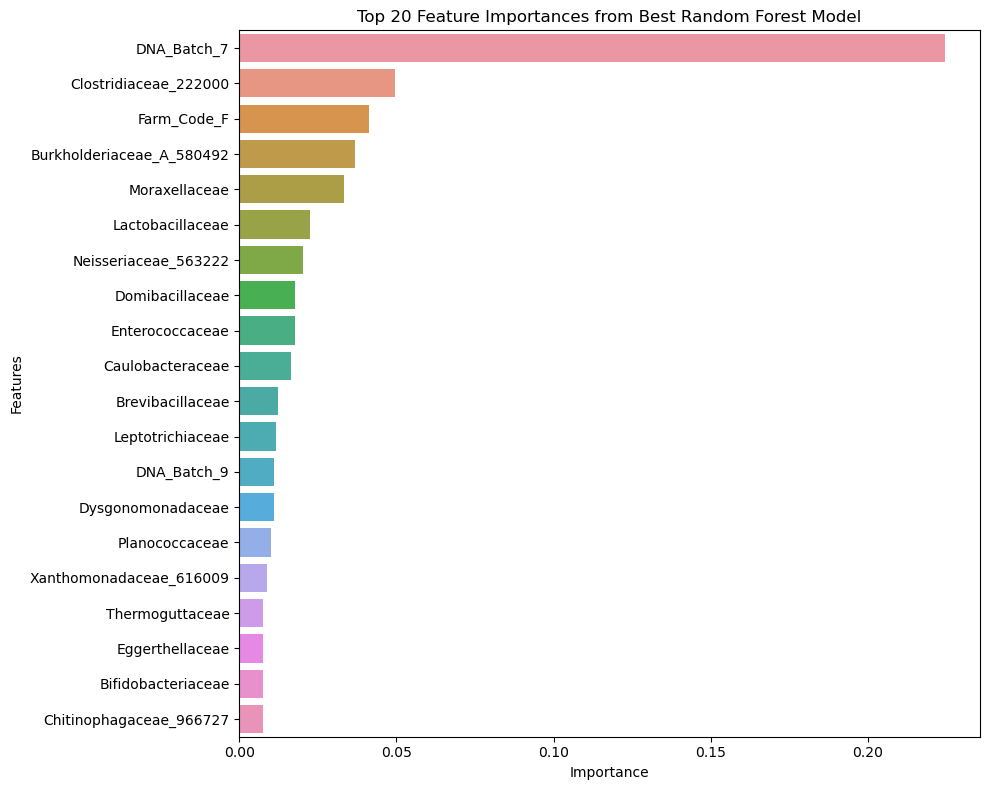

In [29]:

# imp feat
importances_best = best_rf.feature_importances_
feature_importances_best = pd.Series(importances_best, index=feature_names).sort_values(ascending=False)


print(feature_importances_best)

# 20
top_features_best = feature_importances_best.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features_best, y=top_features_best.index)
plt.title('Top 20 Feature Importances from Best Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


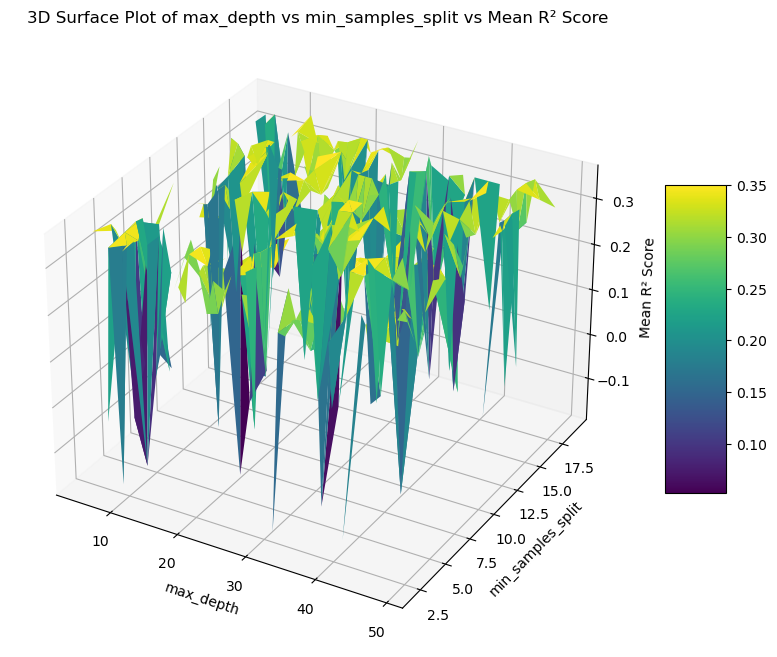

In [19]:

from mpl_toolkits.mplot3d import Axes3D

def plot_3d_param_performance_surface(param_x, param_y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
   
    x = results['param_' + param_x]
    y = results['param_' + param_y]
    z = results['mean_test_score']
    
    
    surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
    
   
    ax.set_xlabel(param_x)
    ax.set_ylabel(param_y)
    ax.set_zlabel('Mean R² Score')
    
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
   
    plt.title(f'3D Surface Plot of {param_x} vs {param_y} vs Mean R² Score')
    
    plt.show()


plot_3d_param_performance_surface('max_depth', 'min_samples_split')


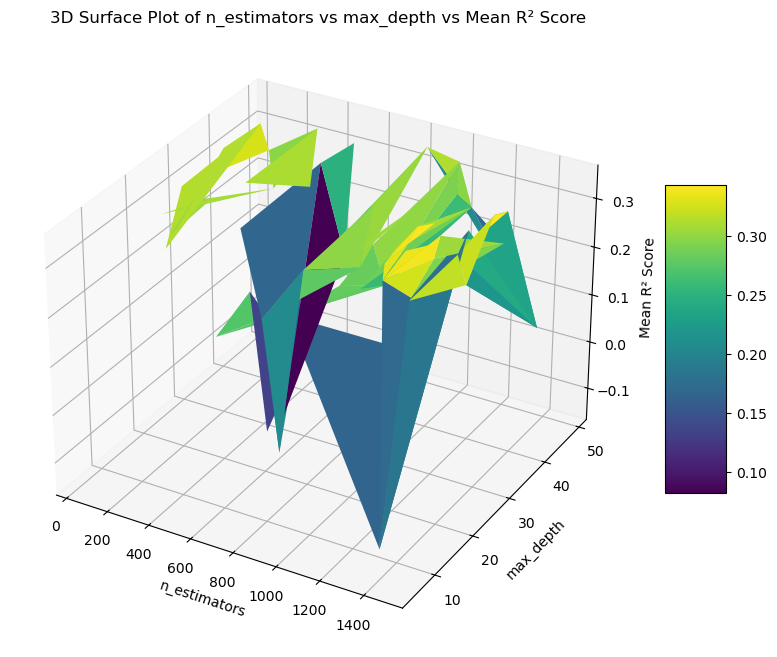

In [23]:
plot_3d_param_performance_surface('n_estimators', 'max_depth')